In [ ]:
#############################################################################
# IMPORTS AND SETUP
#############################################################################
# Set random seed for reproducibility
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True  # Makes training more deterministic
torch.backends.cudnn.benchmark = False     # Can speed up training when input sizes don't change

# Standard imports
import pandas as pd
import numpy as np
import polars as pl
from datetime import datetime, timedelta
import time
import os
#from datasets import load_dataset
import matplotlib.pyplot as plt

from tqdm.auto import tqdm  # Progress bar


# Check and set up GPU (support MPS on Mac)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"使用设备: {device}")

# Print extra info
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
elif device.type == "mps":
    print("使用 Apple Silicon GPU 通过 Metal Performance Shaders (MPS)")

#############################################################################
# 数据加载与处理
#############################################################################

import pandas as pd
import os
import glob
from tqdm.auto import tqdm

# 创建下载目录
os.makedirs("crypto_data", exist_ok=True)
error_files = []
# 数据路径
data_path = "perp_futures_klines"

# 检查数据文件夹是否存在
if not os.path.exists(data_path):
    print(f"错误: 数据文件夹 {data_path} 不存在，请确保已下载数据")
else:
    print(f"数据文件夹存在: {data_path}")
    
    # 查找所有 parquet 文件
    parquet_files = glob.glob(f"{data_path}/**/*.parquet", recursive=True)
    print(f"找到 {len(parquet_files)} 个 parquet 文件")
    
    if len(parquet_files) == 0:
        print("未找到数据文件，请确保数据已正确下载")
    else:
        # 读取所有 parquet 文件并合并
        print("正在读取数据文件...")
        dfs = []
        
        for file in tqdm(parquet_files):
            try:
                df_temp = pd.read_parquet(file, engine='pyarrow' )
                # 从文件名提取 symbol
                file_name = os.path.basename(file)
                symbol = file_name.split('_')[0]
                df_temp['symbol'] = symbol
                
                dfs.append(df_temp)
                
               
                
                
                
            except Exception as e:
                print(f"读取文件 {file} 时出错: {e}")
                
            
            
        # 合并所有数据
        if dfs:
            print("合并所有数据...")
            df = pd.concat(dfs, ignore_index=True)
            
            # 查看数据的前几行
            print("数据预览:")
            print(df.head())
            
            # 检查数据类型和缺失值
            print("\n数据信息:")
            print(df.info())
            print("\n缺失值统计:")
            print(df.isnull().sum())
            
            # 确保 open_time 列是 datetime 类型
            df['open_time'] = pd.to_datetime(df['open_time'])
            
            # 设置特征列
            feature_columns = ['open', 'high', 'low', 'close', 'volume', 'count']
            
            # 计算30分钟收益率（horizon = 30min）
            print("\n计算30分钟收益率...")
            df = df.sort_values(['symbol', 'open_time'])  # 确保数据按 symbol 和时间排序
            df['future_close'] = df.groupby('symbol')['close'].shift(-30)  # 30个时间单位后的收盘价
            df['return_30min'] = df['future_close'] / df['close'] - 1  # 计算收益率
            
            # 删除缺失的目标变量行
            df = df.dropna(subset=['return_30min'])
            
            # 查看处理后的数据
            print("\n处理后的数据预览:")
            print(df.head())
            
            # 数据已经包含所有 symbol，确保它们被正确标记
            symbols = df['symbol'].unique()
            print(f"\n数据集中包含的交易对: {symbols}")
            print(f"总数据行数: {len(df)}")
            
            # 可视化不同 symbol 的数据分布
            plt.figure(figsize=(12, 6))
            df['symbol'].value_counts().plot(kind='bar')
            plt.title('各交易对数据量')
            plt.ylabel('数据点数')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
            
            # 准备特征矩阵 X 和目标变量 Y
            X = df[feature_columns]
            y = df['return_30min']
            
            # 查看特征和目标变量的统计信息
            print("\n特征统计信息:")
            print(X.describe())
            
            print("\n目标变量统计信息:")
            print(y.describe())
            
            # 保存处理后的数据
            print("\n保存处理后的数据...")
            df.to_csv('processed_crypto_data.csv', index=False)
            print("数据处理完成!")
        else:
            print("没有成功读取任何数据文件")

In [ ]:
import pandas as pd
import numpy as np

def align_time_series_fast(df, fill_method='ffill', fill_value=0):
    """
    Fast align time series data for different symbols without lookahead.
    Uses pivot/groupby method for better performance.
    
    Parameters:
    - df: DataFrame with 'open_time' and 'symbol' columns
    - fill_method: Method to fill missing values ('ffill' for forward fill)
    - fill_value: Value to use when there are no previous values (default: 0)
    
    Returns:
    - DataFrame with aligned time series
    """
    # Make sure open_time is datetime
    df['open_time'] = pd.to_datetime(df['open_time'])
    
    # Create a multi-index from all combinations of time and symbol
    all_times = df['open_time'].unique()
    all_symbols = df['symbol'].unique()
    
    # Create a complete index
    idx = pd.MultiIndex.from_product([all_times, all_symbols], names=['open_time', 'symbol'])
    
    # Set multi-index and reindex to get all combinations
    df_indexed = df.set_index(['open_time', 'symbol'])
    aligned_df = df_indexed.reindex(idx)
    
    # Group by symbol and apply forward fill
    if fill_method == 'ffill':
        aligned_df = aligned_df.groupby(level='symbol').ffill()
    
    # Fill remaining NaN with fill_value
    aligned_df = aligned_df.fillna(fill_value)
    
    # Reset index
    aligned_df = aligned_df.reset_index()
    
    return aligned_df.sort_values(['symbol', 'open_time']).reset_index(drop=True)





In [ ]:
combined_df=pd.read_csv('processed_crypto_data.csv')

align_df= align_time_series_fast(combined_df)

In [ ]:
# 存储df为.parquet文件
align_df.to_parquet("aligned_crypto_data.parquet")

In [1]:
#############################################################################
# IMPORTS AND SETUP
#############################################################################
# Set random seed for reproducibility
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True  # Makes training more deterministic
torch.backends.cudnn.benchmark = False     # Can speed up training when input sizes don't change

# Standard imports
import pandas as pd
import numpy as np
import polars as pl
from datetime import datetime, timedelta
import time
import os

from tqdm.auto import tqdm  # Progress bar


# Check and set up GPU (support MPS on Mac)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Print extra info
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
elif device.type == "mps":
    print("Using Apple Silicon GPU via Metal Performance Shaders (MPS)")


# ##### 强制使用CPU
# # os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# device = torch.device("cpu")
# # Force JAX to use the CPU backend only (avoids CUDA OOM in JAX)
# os.environ['JAX_PLATFORMS'] = 'cpu'

Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)


/Users/siluli/Documents/vscodefiles/paper project/zyh/pyEPO/my-PyEPO/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
# 添加项目根目录到搜索路径
sys.path.append('/Documents/vscodefiles/paper project/zyh/pyEPO/my-PyEPO')

import time
import numpy as np
import pandas as pd

# PyEPO imports
from pyepo.data.dataset import optDataset

# Gurobi
import gurobipy as gp
from gurobipy import GRB
from pyepo.model.grb import optGrbModel

# Pyomo
from pyomo import environ as pe
from pyepo.model.omo import optOmoModel # 记得要把 omo 文件夹里的 __init__.py 文件也修改了
from pyepo import EPO

# COPTPy
from coptpy import Envr, COPT
from pyepo.model.copt import optCoptModel

# MPAX
from pyepo.model.mpax import optMpaxModel

In [4]:
import subprocess
import sys

import pandas as pd

# 读取 parquet 文件
df = pd.read_parquet("aligned_crypto_data.parquet")

# 查看数据
df.head()

,open_time,symbol,open,high,low,close,volume,count,future_close,return_30min
0,2025-01-01 00:00:00,1000000MOGUSDT,2.0176,2.0198,2.0150,2.0196,2646.2,125.0,2.0306,0.005447
1,2025-01-01 00:01:00,1000000MOGUSDT,2.0199,2.0212,2.0189,2.0210,1783.3,104.0,2.0349,0.006878
2,2025-01-01 00:02:00,1000000MOGUSDT,2.0209,2.0246,2.0209,2.0240,888.1,115.0,2.0371,0.006472
3,2025-01-01 00:03:00,1000000MOGUSDT,2.0241,2.0253,2.0174,2.0174,9439.2,115.0,2.0402,0.011302
4,2025-01-01 00:04:00,1000000MOGUSDT,2.0177,2.0187,2.0162,2.0162,4998.9,80.0,2.0392,0.011408


# Training and Testing


## 随机生成横截面xy数据

In [5]:
print(df.shape)

(43888350, 10)


In [7]:
#  efficient version using vectorized operations across all columns at once
def minmaxscaler_by_symbol(df, feature_range=(-1, 1), target_columns=None, group_by_column='symbol'):
    """
    Ultra-efficient MinMaxScaler using vectorized groupby operations
    
    Parameters:
    - df: DataFrame to scale
    - feature_range: tuple of (min, max) to scale data to, default (-1, 1)
    - target_columns: list of specific columns to scale
    - group_by_column: column to group by for scaling
    
    Returns:
    - Scaled DataFrame
    """
    # Determine columns to scale
    if target_columns is None:
        numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
        target_columns = [col for col in numeric_columns if col not in ['open_time', group_by_column]]
    
    # Create a copy
    scaled_df = df.copy()
    
    # Get feature range parameters
    feature_min, feature_max = feature_range
    feature_span = feature_max - feature_min
    
    # Get the subset of columns to scale
    data_to_scale = df[target_columns]
    
    # Perform vectorized groupby operations
    grouped = df.groupby(group_by_column)
    
    # Calculate min and max for all columns at once
    group_mins = grouped[target_columns].transform('min')
    group_maxs = grouped[target_columns].transform('max')
    group_ranges = group_maxs - group_mins
    
    # Apply scaling formula vectorized across all columns
    # Handle division by zero for constant values
    scaled_values = np.where(
        group_ranges == 0,
        feature_min,
        (data_to_scale - group_mins) / group_ranges * feature_span + feature_min
    )
    
    # Assign scaled values back to the DataFrame
    scaled_df[target_columns] = scaled_values
    
    return scaled_df

In [8]:
import numpy as np
import pandas as pd

# 首先，检查数据类型
y_col = 'return_30min'  
x_cols = ['open', 'high', 'low', 'close', 'volume','count']
df= minmaxscaler_by_symbol(df,target_columns=x_cols)
print(f"DataFrame type: {type(df)}")

# 使用 pandas 的语法
# 2. Pivot costs matrix: shape (T, N)
cost_pivot = df.pivot_table(
    values=y_col,
    index="open_time",
    columns="symbol",
    aggfunc="first"  # 使用第一个值
)

# 检查一下重复值
duplicates = df.groupby(['open_time', 'symbol']).size()
if (duplicates > 1).any():
    print("Warning: Found duplicate (time, symbol) pairs")
    print("Duplicates sample:")
    print(duplicates[duplicates > 1].head())

# 排序并填充缺失值
cost_pivot = cost_pivot.sort_index()
cost_pivot = cost_pivot.fillna(0)

# 提取时间和符号信息
unique_times = cost_pivot.index.tolist()
unique_symbols = cost_pivot.columns.tolist()

# 转换为 numpy 数组
costs = cost_pivot.values

# 3. Pivot 每个特征并堆叠成 3D 张量 (T, N, k)
feature_mats = []
for x in x_cols:
    mat = df.pivot_table(
        values=x,
        index="open_time",
        columns="symbol",
        aggfunc="first"
    )
    # 排序，填充缺失值
    mat = mat.sort_index().fillna(0)
    
    # 确保列的顺序与 cost_pivot 一致
    mat = mat.reindex(columns=unique_symbols)
    
    feature_mats.append(mat.values)

# 在第三维度堆叠创建 (T, N, k) 张量
features = np.stack(feature_mats, axis=2)  # (T, N, k)

print(f"Data shape: features {features.shape}, costs {costs.shape}")

#############################################################################
# TRAIN-TEST SPLIT
#############################################################################
from sklearn.model_selection import train_test_split


DataFrame type: <class 'pandas.core.frame.DataFrame'>
Data shape: features (131010, 335, 6), costs (131010, 335)


In [10]:
import pickle

def save_data(features, costs, unique_times, unique_symbols, x_cols, name='default', save_dir='./data'):
    """
    Save processed data to disk with a simple name instead of timestamp
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Save numpy arrays
    np.save(f"{save_dir}/features_{name}.npy", features)
    np.save(f"{save_dir}/costs_{name}.npy", costs)
    
    # Save metadata as pickle files
    with open(f"{save_dir}/times_{name}.pkl", 'wb') as f:
        pickle.dump(unique_times, f)
    
    with open(f"{save_dir}/symbols_{name}.pkl", 'wb') as f:
        pickle.dump(unique_symbols, f)
    
    # Save feature dimensions information
    feature_info = {
        'shape': features.shape,
        'feature_names': x_cols
    }
    with open(f"{save_dir}/feature_info_{name}.pkl", 'wb') as f:
        pickle.dump(feature_info, f)
    
    print(f"Data saved to {save_dir} with name '{name}'")


    
    
save_data(features, costs, unique_times, unique_symbols, x_cols, name='crypto_data')
    
    
    

Data saved to ./data with name 'crypto_data'


In [1]:
import time
import numpy as np
import pandas as pd

# PyEPO imports
from pyepo.data.dataset import optDataset

# Gurobi
import gurobipy as gp
from gurobipy import GRB
from pyepo.model.grb import optGrbModel

# Pyomo
from pyomo import environ as pe
from pyepo.model.omo import optOmoModel # 记得要把 omo 文件夹里的 __init__.py 文件也修改了
from pyepo import EPO

# COPTPy
from coptpy import Envr, COPT
from pyepo.model.copt import optCoptModel

# MPAX
from pyepo.model.mpax import optMpaxModel

In [2]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from tqdm import tqdm
from pkg.pyepo.data.dataset import optDataset
from pkg.pyepo.model.grb import optGrbModel

def load_data(name='default', load_dir='./data'):
    """
    Load processed data from disk using a simple name instead of timestamp
    """
    # Load numpy arrays
    features = np.load(f"{load_dir}/features_{name}.npy")
    costs = np.load(f"{load_dir}/costs_{name}.npy")
    
    # Load metadata
    with open(f"{load_dir}/times_{name}.pkl", 'rb') as f:
        unique_times = pickle.load(f)
    
    with open(f"{load_dir}/symbols_{name}.pkl", 'rb') as f:
        unique_symbols = pickle.load(f)
    
    # Load feature information
    with open(f"{load_dir}/feature_info_{name}.pkl", 'rb') as f:
        feature_info = pickle.load(f)
    
    print(f"Loaded data from {load_dir} with name '{name}'")
    print(f"Features shape: {features.shape}")
    print(f"Feature names: {feature_info['feature_names']}")
    
    return features, costs, unique_times, unique_symbols, feature_info
    
# load the data using the same name
features, costs, unique_times, unique_symbols, feature_info = load_data(name='crypto_data')    

Loaded data from ./data with name 'crypto_data'
Features shape: (131010, 335, 6)
Feature names: ['open', 'high', 'low', 'close', 'volume', 'count']


In [3]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB

# 在导入任何 pyepo 模块之前，先修复 HAS_GUROBI
import sys
import importlib

# 强制重新加载模块以确保修改生效
if 'pyepo.model.grb.grbmodel' in sys.modules:
    del sys.modules['pyepo.model.grb.grbmodel']
if 'pyepo.model.grb' in sys.modules:
    del sys.modules['pyepo.model.grb']

# 导入并修复
from pyepo.model.grb import grbmodel
grbmodel.HAS_GUROBI = True

# 现在导入基类
from pyepo.model.grb.grbmodel import optGrbModel


In [4]:
#############################################################################
# OPTIMIZATION PROBLEM PARAMETERS
#############################################################################
# Market neutral optimization model parameters from opt_time_compare.py


# 导入 grbmodel 模块
from pyepo.model.grb import grbmodel

# 强制设置 HAS_GUROBI 为 True
grbmodel.HAS_GUROBI = True


N = features.shape[1]  # Number of assets, updated from data
A = np.ones((1, N))
b = np.array([1.0])
l = np.zeros(N)
u = np.zeros(N) + 1e6

# Generate random positive definite covariance matrix
M = np.random.randn(N, N)
cov_matrix = M.T @ M + np.eye(N) * 1e-3

# Risk and constraint parameters
risk_f     = np.random.randn(N)
risk_abs   = 1.5
single_abs = 0.1
l1_abs     = 1.0
sigma_abs  = 2.5


#############################################################################
# MARKET NEUTRAL OPTIMIZATION MODEL
#############################################################################
class MarketNeutralGrbModel(optGrbModel):
    def __init__(
        self,
        N,
        A,
        b,
        l,
        u,
        minimize=False,
        risk_f=None,
        risk_abs=None,
        single_abs=None,
        l1_abs=None,
        cov_matrix=None,
        sigma_abs=None
    ):
        # 保存所有参数
        self.N = N
        self.A = A
        self.b = b
        self.l = l
        self.u = u
        self.minimize = minimize
        self.risk_f = risk_f
        self.risk_abs = risk_abs
        self.single_abs = single_abs
        self.l1_abs = l1_abs
        self.cov_matrix = cov_matrix
        self.sigma_abs = sigma_abs

        super().__init__()

    def _getModel(self):
        # 新建 Gurobi 模型
        m = gp.Model()

        # 添加原始变量 x[i]
        x = m.addVars(
            self.N,
            lb={i: float(self.l[i]) for i in range(self.N)},
            ub={i: float(self.u[i]) for i in range(self.N)},
            name="x"
        )

        # 用于 L1 约束的辅助变量 t[i]
        t = m.addVars(self.N, lb=0.0, name="t")

        # 设置优化方向
        m.modelSense = GRB.MINIMIZE if self.minimize else GRB.MAXIMIZE

        # ——— 1) 市场中性约束 sum A[0,i] * x[i] == b[0]
        m.addConstr(
            gp.quicksum(self.A[0, i] * x[i] for i in range(self.N)) == float(self.b[0]),
            name="eq_sum"
        )

        # ——— 2) 风险约束 |risk_f' x| <= risk_abs
        expr_r = gp.quicksum(self.risk_f[i] * x[i] for i in range(self.N))
        m.addConstr(expr_r <= float(self.risk_abs), name="risk_ub")
        m.addConstr(expr_r >= -float(self.risk_abs), name="risk_lb")

        # ——— 3) 单项绝对值约束 |x_i| <= single_abs
        for i in range(self.N):
            m.addConstr(x[i] <=  float(self.single_abs),  name=f"single_ub_{i}")
            m.addConstr(x[i] >= -float(self.single_abs), name=f"single_lb_{i}")

        # ——— 4) L1 约束 ∑|x_i| <= l1_abs
        #   实现方式： t[i] >=  x[i], t[i] >= -x[i], 然后 ∑ t[i] <= l1_abs
        for i in range(self.N):
            m.addConstr(t[i] >=  x[i], name=f"t_pos_{i}")
            m.addConstr(t[i] >= -x[i], name=f"t_neg_{i}")
        m.addConstr(t.sum() <= float(self.l1_abs), name="l1_norm")

        # ——— 5) 二次型约束 x' * cov_matrix * x <= sigma_abs
        #     向量化写法： x_vec @ cov_matrix @ x_vec
        x_vec = np.array([x[i] for i in range(self.N)])
        expr_q = x_vec @ self.cov_matrix @ x_vec
        m.addQConstr(expr_q <= float(self.sigma_abs), name="sigma_qc")

        return m, x
    


# Optionally, you can test the model here
# c_test = np.random.rand(N)
# market_neutral_model.setObj(c_test)
# sol = market_neutral_model.solve()
# print(f"Test solution objective value: {market_neutral_model.getObjVal()}")









In [5]:
import numpy as np
import gc
from multiprocessing import get_context, shared_memory, Process
from model_factory import build_market_neutral_model
from pyepo.data.dataset import optDataset

from batch_runner import run_batch_shared

def process_and_combine_shared(features, costs, batch_size=1000, lookback=5, padding_method='zero'):
    ctx = get_context('spawn')
    total_samples = len(features)
    all_feats, all_sols, all_objs = [], [], []

    N = features.shape[1]
    A = np.ones((1, N))
    b = np.array([1.0])
    l = np.zeros(N)
    u = np.zeros(N) + 1e6
    M = np.random.randn(N, N)
    cov_matrix = M.T @ M + np.eye(N) * 1e-3
    risk_f     = np.random.randn(N)
    risk_abs   = 1.5
    single_abs = 0.1
    l1_abs     = 1.0
    sigma_abs  = 2.5

    for i in range(0, total_samples, batch_size):
        start, end = i, min(i + batch_size, total_samples)
        print(f"\n 共享内存子进程处理样本 {start} 到 {end - 1}...")

        feats_batch = features[start:end]
        costs_batch = costs[start:end]

        

        shapes = {
            'feats': (feats_batch.shape[0], feats_batch.shape[1], lookback, feats_batch.shape[2]),
            'sols': (feats_batch.shape[0], feats_batch.shape[1]),
            'objs': (feats_batch.shape[0],1)
        }
        dtypes = {'feats': feats_batch.dtype, 'sols': np.float32, 'objs': np.float32}

        shms = {key: shared_memory.SharedMemory(create=True, size=np.zeros(shapes[key], dtype=dtypes[key]).nbytes)
                for key in shapes}

        shm_names = {k: v.name for k, v in shms.items()}

        p = ctx.Process(
            target=run_batch_shared,
            args=(shm_names, shapes, dtypes, feats_batch, costs_batch, lookback, padding_method,
                  N, A, b, l, u, risk_f, risk_abs, single_abs, l1_abs, cov_matrix, sigma_abs)
        )
        p.start()
        p.join()

        feats_np = np.ndarray(shapes['feats'], dtype=dtypes['feats'], buffer=shms['feats'].buf).copy()
        sols_np = np.ndarray(shapes['sols'], dtype=dtypes['sols'], buffer=shms['sols'].buf).copy()
        objs_np = np.ndarray(shapes['objs'], dtype=dtypes['objs'], buffer=shms['objs'].buf).copy()

        all_feats.append(feats_np)
        all_sols.append(sols_np)
        all_objs.append(objs_np)

        for shm in shms.values():
            shm.close()
            shm.unlink()

        del feats_batch, costs_batch
        gc.collect()

    print("\n 合并所有批次...")
    return {
        'feats': np.concatenate(all_feats, axis=0),
        'costs': costs,
        'sols': np.concatenate(all_sols, axis=0),
        'objs': np.concatenate(all_objs, axis=0),
        'lookback': lookback,
        'padding_method': padding_method
    }

In [6]:
dataset_dict = process_and_combine_shared(
    features=features,
    costs=costs,
    batch_size=500,  # 调整批量大小
    lookback=5,
    padding_method='zero',

)



 共享内存子进程处理样本 0 到 499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.89it/s]



 共享内存子进程处理样本 500 到 999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.67it/s]



 共享内存子进程处理样本 1000 到 1499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.83it/s]



 共享内存子进程处理样本 1500 到 1999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.83it/s]



 共享内存子进程处理样本 2000 到 2499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.85it/s]



 共享内存子进程处理样本 2500 到 2999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.93it/s]



 共享内存子进程处理样本 3000 到 3499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.83it/s]



 共享内存子进程处理样本 3500 到 3999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.52it/s]



 共享内存子进程处理样本 4000 到 4499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.89it/s]



 共享内存子进程处理样本 4500 到 4999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.93it/s]



 共享内存子进程处理样本 5000 到 5499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.89it/s]



 共享内存子进程处理样本 5500 到 5999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]



 共享内存子进程处理样本 6000 到 6499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.92it/s]



 共享内存子进程处理样本 6500 到 6999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 7000 到 7499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.83it/s]



 共享内存子进程处理样本 7500 到 7999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.93it/s]



 共享内存子进程处理样本 8000 到 8499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.82it/s]



 共享内存子进程处理样本 8500 到 8999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.99it/s]



 共享内存子进程处理样本 9000 到 9499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.08it/s]



 共享内存子进程处理样本 9500 到 9999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.99it/s]



 共享内存子进程处理样本 10000 到 10499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [01:00<00:00,  8.25it/s]



 共享内存子进程处理样本 10500 到 10999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.53it/s]



 共享内存子进程处理样本 11000 到 11499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.59it/s]



 共享内存子进程处理样本 11500 到 11999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.17it/s]



 共享内存子进程处理样本 12000 到 12499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.36it/s]



 共享内存子进程处理样本 12500 到 12999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.81it/s]



 共享内存子进程处理样本 13000 到 13499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.64it/s]



 共享内存子进程处理样本 13500 到 13999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.15it/s]



 共享内存子进程处理样本 14000 到 14499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.02it/s]



 共享内存子进程处理样本 14500 到 14999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.74it/s]



 共享内存子进程处理样本 15000 到 15499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:27<00:00, 17.86it/s]



 共享内存子进程处理样本 15500 到 15999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.77it/s]



 共享内存子进程处理样本 16000 到 16499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.75it/s]



 共享内存子进程处理样本 16500 到 16999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:54<00:00,  9.23it/s]



 共享内存子进程处理样本 17000 到 17499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.52it/s]



 共享内存子进程处理样本 17500 到 17999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.59it/s]



 共享内存子进程处理样本 18000 到 18499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.59it/s]



 共享内存子进程处理样本 18500 到 18999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.35it/s]



 共享内存子进程处理样本 19000 到 19499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.64it/s]



 共享内存子进程处理样本 19500 到 19999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.79it/s]



 共享内存子进程处理样本 20000 到 20499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.65it/s]



 共享内存子进程处理样本 20500 到 20999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.59it/s]



 共享内存子进程处理样本 21000 到 21499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:43<00:00, 11.42it/s]



 共享内存子进程处理样本 21500 到 21999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.72it/s]



 共享内存子进程处理样本 22000 到 22499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.61it/s]



 共享内存子进程处理样本 22500 到 22999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.71it/s]



 共享内存子进程处理样本 23000 到 23499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.67it/s]



 共享内存子进程处理样本 23500 到 23999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.53it/s]



 共享内存子进程处理样本 24000 到 24499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.46it/s]



 共享内存子进程处理样本 24500 到 24999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.58it/s]



 共享内存子进程处理样本 25000 到 25499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.42it/s]



 共享内存子进程处理样本 25500 到 25999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.54it/s]



 共享内存子进程处理样本 26000 到 26499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.45it/s]



 共享内存子进程处理样本 26500 到 26999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.35it/s]



 共享内存子进程处理样本 27000 到 27499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.05it/s]



 共享内存子进程处理样本 27500 到 27999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.40it/s]



 共享内存子进程处理样本 28000 到 28499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:50<00:00,  9.93it/s]



 共享内存子进程处理样本 28500 到 28999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.55it/s]



 共享内存子进程处理样本 29000 到 29499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.51it/s]



 共享内存子进程处理样本 29500 到 29999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.58it/s]



 共享内存子进程处理样本 30000 到 30499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.66it/s]



 共享内存子进程处理样本 30500 到 30999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.54it/s]



 共享内存子进程处理样本 31000 到 31499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.37it/s]



 共享内存子进程处理样本 31500 到 31999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:50<00:00,  9.88it/s]



 共享内存子进程处理样本 32000 到 32499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:58<00:00,  8.51it/s]



 共享内存子进程处理样本 32500 到 32999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.23it/s]



 共享内存子进程处理样本 33000 到 33499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:32<00:00, 15.39it/s]



 共享内存子进程处理样本 33500 到 33999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.38it/s]



 共享内存子进程处理样本 34000 到 34499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.61it/s]



 共享内存子进程处理样本 34500 到 34999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.59it/s]



 共享内存子进程处理样本 35000 到 35499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.52it/s]



 共享内存子进程处理样本 35500 到 35999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.69it/s]



 共享内存子进程处理样本 36000 到 36499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.71it/s]



 共享内存子进程处理样本 36500 到 36999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.47it/s]



 共享内存子进程处理样本 37000 到 37499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.38it/s]



 共享内存子进程处理样本 37500 到 37999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.60it/s]



 共享内存子进程处理样本 38000 到 38499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.55it/s]



 共享内存子进程处理样本 38500 到 38999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.14it/s]



 共享内存子进程处理样本 39000 到 39499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:48<00:00, 10.38it/s]



 共享内存子进程处理样本 39500 到 39999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.34it/s]



 共享内存子进程处理样本 40000 到 40499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.25it/s]



 共享内存子进程处理样本 40500 到 40999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.35it/s]



 共享内存子进程处理样本 41000 到 41499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.12it/s]



 共享内存子进程处理样本 41500 到 41999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.20it/s]



 共享内存子进程处理样本 42000 到 42499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.31it/s]



 共享内存子进程处理样本 42500 到 42999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.22it/s]



 共享内存子进程处理样本 43000 到 43499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:28<00:00, 17.29it/s]



 共享内存子进程处理样本 43500 到 43999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:55<00:00,  8.99it/s]



 共享内存子进程处理样本 44000 到 44499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.13it/s]



 共享内存子进程处理样本 44500 到 44999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.21it/s]



 共享内存子进程处理样本 45000 到 45499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.10it/s]



 共享内存子进程处理样本 45500 到 45999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.96it/s]



 共享内存子进程处理样本 46000 到 46499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.97it/s]



 共享内存子进程处理样本 46500 到 46999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]



 共享内存子进程处理样本 47000 到 47499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.66it/s]



 共享内存子进程处理样本 47500 到 47999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.32it/s]



 共享内存子进程处理样本 48000 到 48499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:31<00:00, 15.79it/s]



 共享内存子进程处理样本 48500 到 48999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.53it/s]



 共享内存子进程处理样本 49000 到 49499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:31<00:00, 16.03it/s]



 共享内存子进程处理样本 49500 到 49999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.79it/s]



 共享内存子进程处理样本 50000 到 50499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.88it/s]



 共享内存子进程处理样本 50500 到 50999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]



 共享内存子进程处理样本 51000 到 51499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.71it/s]



 共享内存子进程处理样本 51500 到 51999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.04it/s]



 共享内存子进程处理样本 52000 到 52499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.89it/s]



 共享内存子进程处理样本 52500 到 52999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]



 共享内存子进程处理样本 53000 到 53499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 53500 到 53999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.13it/s]



 共享内存子进程处理样本 54000 到 54499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:31<00:00, 16.07it/s]



 共享内存子进程处理样本 54500 到 54999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.93it/s]



 共享内存子进程处理样本 55000 到 55499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.93it/s]



 共享内存子进程处理样本 55500 到 55999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.70it/s]



 共享内存子进程处理样本 56000 到 56499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.73it/s]



 共享内存子进程处理样本 56500 到 56999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.69it/s]



 共享内存子进程处理样本 57000 到 57499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.78it/s]



 共享内存子进程处理样本 57500 到 57999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.83it/s]



 共享内存子进程处理样本 58000 到 58499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.13it/s]



 共享内存子进程处理样本 58500 到 58999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [01:00<00:00,  8.24it/s]



 共享内存子进程处理样本 59000 到 59499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.04it/s]



 共享内存子进程处理样本 59500 到 59999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.03it/s]



 共享内存子进程处理样本 60000 到 60499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.05it/s]



 共享内存子进程处理样本 60500 到 60999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.01it/s]



 共享内存子进程处理样本 61000 到 61499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 61500 到 61999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]



 共享内存子进程处理样本 62000 到 62499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]



 共享内存子进程处理样本 62500 到 62999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.00it/s]



 共享内存子进程处理样本 63000 到 63499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.03it/s]



 共享内存子进程处理样本 63500 到 63999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.99it/s]



 共享内存子进程处理样本 64000 到 64499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.15it/s]



 共享内存子进程处理样本 64500 到 64999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.45it/s]



 共享内存子进程处理样本 65000 到 65499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.72it/s]



 共享内存子进程处理样本 65500 到 65999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.18it/s]



 共享内存子进程处理样本 66000 到 66499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.17it/s]



 共享内存子进程处理样本 66500 到 66999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:34<00:00, 14.47it/s]



 共享内存子进程处理样本 67000 到 67499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.05it/s]



 共享内存子进程处理样本 67500 到 67999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.04it/s]



 共享内存子进程处理样本 68000 到 68499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.01it/s]



 共享内存子进程处理样本 68500 到 68999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.07it/s]



 共享内存子进程处理样本 69000 到 69499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.32it/s]



 共享内存子进程处理样本 69500 到 69999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.21it/s]



 共享内存子进程处理样本 70000 到 70499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 70500 到 70999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.16it/s]



 共享内存子进程处理样本 71000 到 71499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.17it/s]



 共享内存子进程处理样本 71500 到 71999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.01it/s]



 共享内存子进程处理样本 72000 到 72499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.58it/s]



 共享内存子进程处理样本 72500 到 72999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.12it/s]



 共享内存子进程处理样本 73000 到 73499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.04it/s]



 共享内存子进程处理样本 73500 到 73999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.81it/s]



 共享内存子进程处理样本 74000 到 74499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.90it/s]



 共享内存子进程处理样本 74500 到 74999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.04it/s]



 共享内存子进程处理样本 75000 到 75499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.88it/s]



 共享内存子进程处理样本 75500 到 75999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 76000 到 76499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.56it/s]



 共享内存子进程处理样本 76500 到 76999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.97it/s]



 共享内存子进程处理样本 77000 到 77499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]



 共享内存子进程处理样本 77500 到 77999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:36<00:00, 13.62it/s]



 共享内存子进程处理样本 78000 到 78499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:59<00:00,  8.44it/s]



 共享内存子进程处理样本 78500 到 78999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.03it/s]



 共享内存子进程处理样本 79000 到 79499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.93it/s]



 共享内存子进程处理样本 79500 到 79999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.62it/s]



 共享内存子进程处理样本 80000 到 80499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]



 共享内存子进程处理样本 80500 到 80999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.04it/s]



 共享内存子进程处理样本 81000 到 81499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.98it/s]



 共享内存子进程处理样本 81500 到 81999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.99it/s]



 共享内存子进程处理样本 82000 到 82499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.02it/s]



 共享内存子进程处理样本 82500 到 82999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.10it/s]



 共享内存子进程处理样本 83000 到 83499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]



 共享内存子进程处理样本 83500 到 83999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.92it/s]



 共享内存子进程处理样本 84000 到 84499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.06it/s]



 共享内存子进程处理样本 84500 到 84999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.79it/s]



 共享内存子进程处理样本 85000 到 85499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.14it/s]



 共享内存子进程处理样本 85500 到 85999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.15it/s]



 共享内存子进程处理样本 86000 到 86499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.15it/s]



 共享内存子进程处理样本 86500 到 86999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.15it/s]



 共享内存子进程处理样本 87000 到 87499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.04it/s]



 共享内存子进程处理样本 87500 到 87999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.81it/s]



 共享内存子进程处理样本 88000 到 88499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.13it/s]



 共享内存子进程处理样本 88500 到 88999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.96it/s]



 共享内存子进程处理样本 89000 到 89499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 89500 到 89999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.80it/s]



 共享内存子进程处理样本 90000 到 90499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]



 共享内存子进程处理样本 90500 到 90999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.03it/s]



 共享内存子进程处理样本 91000 到 91499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.15it/s]



 共享内存子进程处理样本 91500 到 91999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.84it/s]



 共享内存子进程处理样本 92000 到 92499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.61it/s]



 共享内存子进程处理样本 92500 到 92999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]



 共享内存子进程处理样本 93000 到 93499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.02it/s]



 共享内存子进程处理样本 93500 到 93999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.99it/s]



 共享内存子进程处理样本 94000 到 94499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.98it/s]



 共享内存子进程处理样本 94500 到 94999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]



 共享内存子进程处理样本 95000 到 95499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.19it/s]



 共享内存子进程处理样本 95500 到 95999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.14it/s]



 共享内存子进程处理样本 96000 到 96499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.16it/s]



 共享内存子进程处理样本 96500 到 96999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.09it/s]



 共享内存子进程处理样本 97000 到 97499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]



 共享内存子进程处理样本 97500 到 97999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.75it/s]



 共享内存子进程处理样本 98000 到 98499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.01it/s]



 共享内存子进程处理样本 98500 到 98999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 99000 到 99499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.79it/s]



 共享内存子进程处理样本 99500 到 99999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.83it/s]



 共享内存子进程处理样本 100000 到 100499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]



 共享内存子进程处理样本 100500 到 100999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.98it/s]



 共享内存子进程处理样本 101000 到 101499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.86it/s]



 共享内存子进程处理样本 101500 到 101999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.90it/s]



 共享内存子进程处理样本 102000 到 102499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 102500 到 102999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.06it/s]



 共享内存子进程处理样本 103000 到 103499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.16it/s]



 共享内存子进程处理样本 103500 到 103999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.37it/s]



 共享内存子进程处理样本 104000 到 104499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.66it/s]



 共享内存子进程处理样本 104500 到 104999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.00it/s]



 共享内存子进程处理样本 105000 到 105499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 105500 到 105999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.04it/s]



 共享内存子进程处理样本 106000 到 106499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.11it/s]



 共享内存子进程处理样本 106500 到 106999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.14it/s]



 共享内存子进程处理样本 107000 到 107499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.03it/s]



 共享内存子进程处理样本 107500 到 107999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.10it/s]



 共享内存子进程处理样本 108000 到 108499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]



 共享内存子进程处理样本 108500 到 108999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.87it/s]



 共享内存子进程处理样本 109000 到 109499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.95it/s]



 共享内存子进程处理样本 109500 到 109999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]



 共享内存子进程处理样本 110000 到 110499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.90it/s]



 共享内存子进程处理样本 110500 到 110999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]



 共享内存子进程处理样本 111000 到 111499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.01it/s]



 共享内存子进程处理样本 111500 到 111999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.07it/s]



 共享内存子进程处理样本 112000 到 112499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.06it/s]



 共享内存子进程处理样本 112500 到 112999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.01it/s]



 共享内存子进程处理样本 113000 到 113499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.03it/s]



 共享内存子进程处理样本 113500 到 113999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.97it/s]



 共享内存子进程处理样本 114000 到 114499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.80it/s]



 共享内存子进程处理样本 114500 到 114999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.65it/s]



 共享内存子进程处理样本 115000 到 115499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.78it/s]



 共享内存子进程处理样本 115500 到 115999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.73it/s]



 共享内存子进程处理样本 116000 到 116499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.81it/s]



 共享内存子进程处理样本 116500 到 116999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.05it/s]



 共享内存子进程处理样本 117000 到 117499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.97it/s]



 共享内存子进程处理样本 117500 到 117999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.05it/s]



 共享内存子进程处理样本 118000 到 118499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.07it/s]



 共享内存子进程处理样本 118500 到 118999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.99it/s]



 共享内存子进程处理样本 119000 到 119499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.84it/s]



 共享内存子进程处理样本 119500 到 119999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.24it/s]



 共享内存子进程处理样本 120000 到 120499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:31<00:00, 16.11it/s]



 共享内存子进程处理样本 120500 到 120999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.48it/s]



 共享内存子进程处理样本 121000 到 121499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:32<00:00, 15.17it/s]



 共享内存子进程处理样本 121500 到 121999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:33<00:00, 14.97it/s]



 共享内存子进程处理样本 122000 到 122499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:30<00:00, 16.23it/s]



 共享内存子进程处理样本 122500 到 122999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.03it/s]



 共享内存子进程处理样本 123000 到 123499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.00it/s]



 共享内存子进程处理样本 123500 到 123999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.07it/s]



 共享内存子进程处理样本 124000 到 124499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.91it/s]



 共享内存子进程处理样本 124500 到 124999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.94it/s]



 共享内存子进程处理样本 125000 到 125499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.14it/s]



 共享内存子进程处理样本 125500 到 125999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.02it/s]



 共享内存子进程处理样本 126000 到 126499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.02it/s]



 共享内存子进程处理样本 126500 到 126999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.07it/s]



 共享内存子进程处理样本 127000 到 127499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.17it/s]



 共享内存子进程处理样本 127500 到 127999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.08it/s]



 共享内存子进程处理样本 128000 到 128499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.09it/s]



 共享内存子进程处理样本 128500 到 128999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.96it/s]



 共享内存子进程处理样本 129000 到 129499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.92it/s]



 共享内存子进程处理样本 129500 到 129999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 17.08it/s]



 共享内存子进程处理样本 130000 到 130499...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.87it/s]



 共享内存子进程处理样本 130500 到 130999...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 500/500 [00:29<00:00, 16.98it/s]



 共享内存子进程处理样本 131000 到 131009...
Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06

Optimizing for optDataset...


100%|██████████| 10/10 [00:00<00:00, 17.72it/s]



 合并所有批次...


In [ ]:
import numpy as np
import torch
from tqdm import tqdm
import gc  # 垃圾回收



# 保存处理结果
def save_dataset_dict(dataset_dict, filename):
    """保存数据集字典到文件"""
    np.savez(
        filename,
        feats=dataset_dict['feats'],
        costs=dataset_dict['costs'],
        sols=dataset_dict['sols'],
        objs=dataset_dict['objs'],
        lookback=dataset_dict['lookback'],
        padding_method=dataset_dict['padding_method']
    )



# Create an instance of the market neutral model for testing
market_neutral_model = MarketNeutralGrbModel(
    N, A, b, l, u, minimize=False,
    risk_f=risk_f, risk_abs=risk_abs,
    single_abs=single_abs, l1_abs=l1_abs,
    cov_matrix=cov_matrix, sigma_abs=sigma_abs
)

# 保存处理后的数据
save_dataset_dict(dataset_dict, 'large_market_neutral_dataset.npz')



Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06


In [1]:
import time
import numpy as np
import pandas as pd

# PyEPO imports
from pyepo.data.dataset import optDataset

# Gurobi
import gurobipy as gp
from gurobipy import GRB
from pyepo.model.grb import optGrbModel

# Pyomo
from pyomo import environ as pe
from pyepo.model.omo import optOmoModel # 记得要把 omo 文件夹里的 __init__.py 文件也修改了
from pyepo import EPO

# COPTPy
from coptpy import Envr, COPT
from pyepo.model.copt import optCoptModel

# MPAX
from pyepo.model.mpax import optMpaxModel

In [2]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from tqdm import tqdm
from pkg.pyepo.data.dataset import optDataset
from pkg.pyepo.model.grb import optGrbModel

def load_data(name='default', load_dir='./data'):
    """
    Load processed data from disk using a simple name instead of timestamp
    """
    # Load numpy arrays
    features = np.load(f"{load_dir}/features_{name}.npy")
    costs = np.load(f"{load_dir}/costs_{name}.npy")
    
    # Load metadata
    with open(f"{load_dir}/times_{name}.pkl", 'rb') as f:
        unique_times = pickle.load(f)
    
    with open(f"{load_dir}/symbols_{name}.pkl", 'rb') as f:
        unique_symbols = pickle.load(f)
    
    # Load feature information
    with open(f"{load_dir}/feature_info_{name}.pkl", 'rb') as f:
        feature_info = pickle.load(f)
    
    print(f"Loaded data from {load_dir} with name '{name}'")
    print(f"Features shape: {features.shape}")
    print(f"Feature names: {feature_info['feature_names']}")
    
    return features, costs, unique_times, unique_symbols, feature_info
    
# load the data using the same name
features, costs, unique_times, unique_symbols, feature_info = load_data(name='crypto_data')    

Loaded data from ./data with name 'crypto_data'
Features shape: (131010, 335, 6)
Feature names: ['open', 'high', 'low', 'close', 'volume', 'count']


In [3]:
#############################################################################
# OPTIMIZATION PROBLEM PARAMETERS
#############################################################################
# Market neutral optimization model parameters from opt_time_compare.py


# 导入 grbmodel 模块
from pyepo.model.grb import grbmodel

# 强制设置 HAS_GUROBI 为 True
grbmodel.HAS_GUROBI = True


N = features.shape[1]  # Number of assets, updated from data
A = np.ones((1, N))
b = np.array([1.0])
l = np.zeros(N)
u = np.zeros(N) + 1e6

# Generate random positive definite covariance matrix
M = np.random.randn(N, N)
cov_matrix = M.T @ M + np.eye(N) * 1e-3

# Risk and constraint parameters
risk_f     = np.random.randn(N)
risk_abs   = 1.5
single_abs = 0.1
l1_abs     = 1.0
sigma_abs  = 2.5


#############################################################################
# MARKET NEUTRAL OPTIMIZATION MODEL
#############################################################################
class MarketNeutralGrbModel(optGrbModel):
    def __init__(
        self,
        N,
        A,
        b,
        l,
        u,
        minimize=False,
        risk_f=None,
        risk_abs=None,
        single_abs=None,
        l1_abs=None,
        cov_matrix=None,
        sigma_abs=None
    ):
        # 保存所有参数
        self.N = N
        self.A = A
        self.b = b
        self.l = l
        self.u = u
        self.minimize = minimize
        self.risk_f = risk_f
        self.risk_abs = risk_abs
        self.single_abs = single_abs
        self.l1_abs = l1_abs
        self.cov_matrix = cov_matrix
        self.sigma_abs = sigma_abs

        super().__init__()

    def _getModel(self):
        # 新建 Gurobi 模型
        m = gp.Model()

        # 添加原始变量 x[i]
        x = m.addVars(
            self.N,
            lb={i: float(self.l[i]) for i in range(self.N)},
            ub={i: float(self.u[i]) for i in range(self.N)},
            name="x"
        )

        # 用于 L1 约束的辅助变量 t[i]
        t = m.addVars(self.N, lb=0.0, name="t")

        # 设置优化方向
        m.modelSense = GRB.MINIMIZE if self.minimize else GRB.MAXIMIZE

        # ——— 1) 市场中性约束 sum A[0,i] * x[i] == b[0]
        m.addConstr(
            gp.quicksum(self.A[0, i] * x[i] for i in range(self.N)) == float(self.b[0]),
            name="eq_sum"
        )

        # ——— 2) 风险约束 |risk_f' x| <= risk_abs
        expr_r = gp.quicksum(self.risk_f[i] * x[i] for i in range(self.N))
        m.addConstr(expr_r <= float(self.risk_abs), name="risk_ub")
        m.addConstr(expr_r >= -float(self.risk_abs), name="risk_lb")

        # ——— 3) 单项绝对值约束 |x_i| <= single_abs
        for i in range(self.N):
            m.addConstr(x[i] <=  float(self.single_abs),  name=f"single_ub_{i}")
            m.addConstr(x[i] >= -float(self.single_abs), name=f"single_lb_{i}")

        # ——— 4) L1 约束 ∑|x_i| <= l1_abs
        #   实现方式： t[i] >=  x[i], t[i] >= -x[i], 然后 ∑ t[i] <= l1_abs
        for i in range(self.N):
            m.addConstr(t[i] >=  x[i], name=f"t_pos_{i}")
            m.addConstr(t[i] >= -x[i], name=f"t_neg_{i}")
        m.addConstr(t.sum() <= float(self.l1_abs), name="l1_norm")

        # ——— 5) 二次型约束 x' * cov_matrix * x <= sigma_abs
        #     向量化写法： x_vec @ cov_matrix @ x_vec
        x_vec = np.array([x[i] for i in range(self.N)])
        expr_q = x_vec @ self.cov_matrix @ x_vec
        m.addQConstr(expr_q <= float(self.sigma_abs), name="sigma_qc")

        return m, x
    


# Optionally, you can test the model here
# c_test = np.random.rand(N)
# market_neutral_model.setObj(c_test)
# sol = market_neutral_model.solve()
# print(f"Test solution objective value: {market_neutral_model.getObjVal()}")



# Create an instance of the market neutral model for testing
market_neutral_model = MarketNeutralGrbModel(
    N, A, b, l, u, minimize=False,
    risk_f=risk_f, risk_abs=risk_abs,
    single_abs=single_abs, l1_abs=l1_abs,
    cov_matrix=cov_matrix, sigma_abs=sigma_abs
)





Set parameter Username
Academic license - for non-commercial use only - expires 2026-05-06


In [4]:
# 加载数据集

from pyepo.data.dataset import optDataset
import numpy as np

def load_dataset_dict(filename):
    """从文件加载数据集字典"""
    data = np.load(filename, allow_pickle=True)
    return {
        'feats': data['feats'],
        'costs': data['costs'],
        'sols': data['sols'],
        'objs': data['objs'],
        'lookback': data['lookback'].item(),
        'padding_method': str(data['padding_method'])
    }

# 从字典创建数据集
def create_dataset_from_dict(dataset_dict, model):
    """从字典创建optDataset实例，并载入预计算的sols和objs"""
    dataset = optDataset(
        model=model,
        feats=dataset_dict['feats'],
        costs=dataset_dict['costs'],
        lookback=dataset_dict['lookback'],
        padding_method=dataset_dict['padding_method'],
        precomputed =True
    )
    
    # 用预计算的解替换
    dataset.sols = dataset_dict['sols']
    dataset.objs = dataset_dict['objs']
    
    return dataset


# 之后使用时，可以直接加载而无需重新计算
loaded_dict = load_dataset_dict('large_market_neutral_dataset.npz')
dataset = create_dataset_from_dict(loaded_dict, market_neutral_model)

>>> Precomputed mode enabled. Skipping time series processing and solution computation.


In [5]:
from sklearn.model_selection import train_test_split



# 获取索引并进行分割
indices = list(range(len(dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# 创建 Subset 类
from torch.utils.data import Subset

dataset_train = Subset(dataset, train_indices)
dataset_test = Subset(dataset, test_indices)

# 现在 dataset_train 和 dataset_test 都是 optDataset 对象
print(f"Training size: {len(dataset_train)}")
print(f"Test size: {len(dataset_test)}")



Training size: 104808
Test size: 26202


In [6]:
##########################
# 一个小一点的子集测试一下：
###########################

from sklearn.model_selection import train_test_split



# 获取索引并进行分割
indices = list(range(100))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# 创建 Subset 类
from torch.utils.data import Subset

dataset_train = Subset(dataset, train_indices)
dataset_test = Subset(dataset, test_indices)

# 现在 dataset_train 和 dataset_test 都是 optDataset 对象
print(f"Training size: {len(dataset_train)}")
print(f"Test size: {len(dataset_test)}")

Training size: 80
Test size: 20


In [7]:
#############################################################################
# DATA LOADERS WITH PREFETCHING
#############################################################################
import torch
from torch.utils.data import DataLoader
# Find optimal batch size based on GPU memory
# Start with a reasonable default
batch_size = 8  

generator = torch.Generator()
generator.manual_seed(42)

# Configure data loaders with prefetching
loader_train = DataLoader(
    dataset_train, 
    batch_size=batch_size, 
    shuffle=True,
    generator=generator # 固定data loader的生成器 - 用于对比MLP & MLP_Forloop
    # pin_memory=True,  # Speed up host to GPU transfers
    # num_workers=2,    # Prefetch in parallel
    # persistent_workers=True  # Keep workers alive between epochs
)

loader_test = DataLoader(
    dataset_test, 
    batch_size=batch_size, 
    shuffle=False,
    # pin_memory=True,
    # num_workers=1
)

# move loader to device for logging regret
def device_loader(loader, device):
    for batch in loader:
        x, c, w, z = batch
        yield x.to(device), c.to(device), w.to(device), z.to(device)

## 预测模型

In [ ]:
#############################################################################
# PREDICTION MODEL
#############################################################################
from torch import nn
import torch
# torch.manual_seed(42)  


class EnhancedLinearRegression(nn.Module):
    """
    Enhanced linear regression model with batch normalization
    for improved training stability
    """
    def __init__(self, k: int, dropout_rate=0.0):
        super().__init__()
        # Feature normalization
        self.batch_norm = nn.BatchNorm1d(k)
        # Optional dropout for regularization
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        # Linear layer - maps k features to 1 output
        self.linear = nn.Linear(in_features=k, out_features=1)
        
        # Initialize weights properly
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        # x: (batch_size, N, k) -> reshape for batch norm
        batch_size, N, k = x.shape
        x_reshaped = x.reshape(-1, k)  # (batch_size*N, k)
        
        # Apply batch normalization
        x_normalized = self.batch_norm(x_reshaped)
        
        # Apply dropout if enabled
        if self.dropout is not None:
            x_normalized = self.dropout(x_normalized)
            
        # Apply linear layer
        output = self.linear(x_normalized)  # (batch_size*N, 1)
        
        # Reshape back to original dimensions
        output = output.reshape(batch_size, N)  # (batch_size, N)
        
        return output

# Initialize model and move to GPU
reg = EnhancedLinearRegression(k=k, dropout_rate=0.1).to(device)

# Print model summary
print("Model architecture:")
for name, param in reg.named_parameters():
    print(f"{name:20s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_Grad: {param.requires_grad}")
    # print  and param.grad
    print(f"Value: {param.data} | Grad: {param.grad}")
    
    
print(f"Total parameters: {sum(p.numel() for p in reg.parameters())}")


In [ ]:
class TwoLayerMLP(nn.Module):
    """
    Two-layer MLP model with batch normalization and optional dropout
    """
    def __init__(self, k: int, hidden_dim: int=32, dropout_rate=0.0):
        super().__init__()
        # Feature normalization
        self.batch_norm = nn.BatchNorm1d(k)
        
        # First layer: k -> hidden_dim
        self.fc1 = nn.Linear(k, hidden_dim)
        
        # Second layer: hidden_dim -> 1
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        # Activation function
        self.activation = nn.ReLU()
        
        # Optional dropout for regularization
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate > 0 else None
        
        # Initialize weights properly
        nn.init.xavier_normal(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_normal(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)
    
    def forward(self, x):
        # x: (batch_size, N, k) -> reshape for batch norm
        batch_size, N, k = x.shape
        x_reshaped = x.reshape(-1, k) # (batch_size*N, k)
        
        # Apply batch normalization
        x_normalized = self.batch_norm(x_reshaped)
        
        # First linear layer + activation
        x_hidden = self.fc1(x_normalized)
        x_hidden = self.activation(x_hidden)
        
        # Optional dropout 
        if self.dropout is not None:
            x_hidden = self.dropout(x_hidden)
        
        # Second linear layer (output)
        output = self.fc2(x_hidden) # (batch_size*N, 1)
        
        # Reshape back to (batch_size, N)
        output = output.reshape(batch_size, N)
        
        return output
    

# Initialize model and move to gpu
mlp = TwoLayerMLP(k=k, hidden_dim=32, dropout_rate=0.0).to(device)

# Print model summary
print("Model architecture:")
for name, param in mlp.named_parameters():
    print(f"{name:20s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_Grad: {param.requires_grad}")
    # print  and param.grad
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")

In [ ]:
class TwoLayerMLPForloop(TwoLayerMLP):
    """
    Same structure as TwoLayerMLP, but manually apply forward pass one by one
    """
    def forward(self, x):
        batch_size, N, k = x.shape
        outputs = []
        # (1) BatchNorm
        x_norm = self.batch_norm(x.reshape(-1, k)).reshape(batch_size, N, k)

        for t in range(batch_size):
            for n in range(N):
                x_single = x_norm[t, n, :]  # shape (k,)

                # (2) First linear layer + activation
                x_hidden = self.activation(self.fc1(x_single))  # (1, hidden_dim)
            
                # (3) Optional dropout
                if self.dropout is not None:
                    x_hidden = self.dropout(x_hidden)

                # (4) Second linear layer (output)
                x_out = self.fc2(x_hidden)  # (1, 1)

                outputs.append(x_out.squeeze())  # squeeze to scalar
        
        # Collect all outputs
        outputs = torch.stack(outputs)  # shape (batch_size * N,)
        outputs = outputs.view(batch_size, N)  # reshape back
        return outputs
    
# Initialize model and move to gpu
mlp_fl = TwoLayerMLPForloop(k=k, hidden_dim=32, dropout_rate=0.0).to(device)
mlp_fl.load_state_dict(mlp.state_dict()) # 保证两个版本下参数初始化一致

# Print model summary
print("Model architecture:")
for name, param in mlp_fl.named_parameters():
    print(f"{name:20s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_Grad: {param.requires_grad}")
    # print  and param.grad
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")

In [8]:
import torch
import torch.nn as nn
#############################################################################
# IMPORTS AND SETUP
#############################################################################
# Set random seed for reproducibility
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True  # Makes training more deterministic
torch.backends.cudnn.benchmark = False     # Can speed up training when input sizes don't change

# Standard imports
import pandas as pd
import numpy as np
import polars as pl
from datetime import datetime, timedelta
import time
import os

from tqdm.auto import tqdm  # Progress bar


# Check and set up GPU (support MPS on Mac)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Print extra info
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.empty_cache()
elif device.type == "mps":
    print("Using Apple Silicon GPU via Metal Performance Shaders (MPS)")




class TwoLayerLSTMForloop(nn.Module):
    """
    LSTM 模型处理时间序列数据 (T, N, lookback, k)
    """
    def __init__(self, k, hidden_dim=32, lstm_hidden_dim=64, dropout_rate=0.0):
        super(TwoLayerLSTMForloop, self).__init__()
        self.k = k
        self.hidden_dim = hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        
        # (1) LSTM 层处理时间序列
        self.lstm = nn.LSTM(k, lstm_hidden_dim, batch_first=True)
        
        # (2) BatchNorm 处理 LSTM 输出
        self.batch_norm = nn.BatchNorm1d(lstm_hidden_dim)
        
        # (3) 两层全连接网络
        self.fc1 = nn.Linear(lstm_hidden_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        
        # (4) Dropout
        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.dropout = None
    
    def forward(self, x):
        # x shape: (batch_size, N, lookback, k)
        batch_size, N, lookback, k = x.shape
        
        # 重塑为 LSTM 输入: (batch_size*N, lookback, k)
        x_lstm = x.reshape(-1, lookback, k)
        
        # LSTM 处理
        lstm_out, (h_n, c_n) = self.lstm(x_lstm)
        # lstm_out shape: (batch_size*N, lookback, lstm_hidden_dim)
        # h_n shape: (1, batch_size*N, lstm_hidden_dim)
        
        # 使用最后一个时间步的输出
        lstm_final = lstm_out[:, -1, :]  # shape: (batch_size*N, lstm_hidden_dim)
        
        # BatchNorm
        x_norm = self.batch_norm(lstm_final)  # shape: (batch_size*N, lstm_hidden_dim)
        
        # 全连接层处理
        outputs = []
        for i in range(batch_size * N):
            x_single = x_norm[i]  # shape: (lstm_hidden_dim,)
            
            # 第一层线性变换 + 激活
            x_hidden = self.activation(self.fc1(x_single))  # shape: (hidden_dim,)
            
            # Dropout
            if self.dropout is not None:
                x_hidden = self.dropout(x_hidden)
            
            # 第二层线性变换
            x_out = self.fc2(x_hidden)  # shape: (1,)
            
            outputs.append(x_out.squeeze())  # squeeze to scalar
        
        # 整合输出
        outputs = torch.stack(outputs)  # shape: (batch_size*N,)
        outputs = outputs.view(batch_size, N)  # reshape back to (batch_size, N)
        
        return outputs

# 另一个更高效的版本（不使用 for loop）
class TwoLayerLSTM(nn.Module):
    """
    更高效的 LSTM 实现，处理时间序列数据
    """
    def __init__(self, k, hidden_dim=32, lstm_hidden_dim=64, dropout_rate=0.0):
        super(TwoLayerLSTM, self).__init__()
        self.k = k
        self.hidden_dim = hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        
        # LSTM 层
        self.lstm = nn.LSTM(k, lstm_hidden_dim, batch_first=True)
        
        # 全连接层
        self.fc_layers = nn.Sequential(
            nn.BatchNorm1d(lstm_hidden_dim),
            nn.Linear(lstm_hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate) if dropout_rate > 0 else nn.Identity(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        # x shape: (batch_size, N, lookback, k)
        batch_size, N, lookback, k = x.shape
        
        # 重塑为 LSTM 输入: (batch_size*N, lookback, k)
        x_lstm = x.reshape(-1, lookback, k)
        
        # LSTM 处理
        lstm_out, _ = self.lstm(x_lstm)
        # 使用最后一个时间步的输出
        lstm_final = lstm_out[:, -1, :]  # shape: (batch_size*N, lstm_hidden_dim)
        
        # 全连接层处理
        output = self.fc_layers(lstm_final)  # shape: (batch_size*N, 1)
        
        # 重塑为最终输出
        output = output.view(batch_size, N)  # shape: (batch_size, N)
        
        return output

# Initialize model and move to gpu
lstm_fl = TwoLayerLSTMForloop(k=6, hidden_dim=32, lstm_hidden_dim=64, dropout_rate=0.0).to(device)

# 更高效版本
lstm_efficient = TwoLayerLSTM(k=6, hidden_dim=32, lstm_hidden_dim=64, dropout_rate=0.0).to(device)

# Print model summary
print("Model architecture:")
for name, param in lstm_fl.named_parameters():
    print(f"{name:30s} | Shape: {param.data.shape} | Parameters: {param.numel()} | require_grad: {param.requires_grad}")
    print(f"Mean Value: {param.data.mean()} | Grad: {param.grad}")
    print("-" * 80)

# 测试两个模型的一致性
with torch.no_grad():
    # 创建测试数据
    test_data = torch.randn(4, 5, 5, 6).to(device)  # (batch_size=4, N=5, lookback=5, k=features)
    
    output_forloop = lstm_fl(test_data)
    output_efficient = lstm_efficient(test_data)
    
    print(f"Output shapes - Forloop: {output_forloop.shape}, Efficient: {output_efficient.shape}")

/Users/siluli/Documents/vscodefiles/paper project/zyh/pyEPO/my-PyEPO/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps
Using Apple Silicon GPU via Metal Performance Shaders (MPS)
Model architecture:
lstm.weight_ih_l0              | Shape: torch.Size([256, 6]) | Parameters: 1536 | require_grad: True
Mean Value: -0.0016327118501067162 | Grad: None
--------------------------------------------------------------------------------
lstm.weight_hh_l0              | Shape: torch.Size([256, 64]) | Parameters: 16384 | require_grad: True
Mean Value: -9.67081286944449e-05 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_ih_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: 0.00032716430723667145 | Grad: None
--------------------------------------------------------------------------------
lstm.bias_hh_l0                | Shape: torch.Size([256]) | Parameters: 256 | require_grad: True
Mean Value: -0.003291622269898653 | Grad: None
-----------------------------------------------------------------------

## 训练函数

In [9]:
#############################################################################
# TRAINING WITH MIXED PRECISION
#############################################################################
import time
from torch.amp import GradScaler, autocast
import pyepo

def trainModel(model, loss_func, method_name, num_epochs=5, lr=1e-3):
    """
    Enhanced training function with:
    - Mixed precision for faster GPU training
    - Learning rate scheduling
    - Progress bars
    - Detailed logging
    - Memory-efficient tensor handling
    """
    # Set up optimizer with weight decay for regularization
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler for better convergence
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=1
    )
    
    # Enable mixed precision training
    scaler = GradScaler(enabled=(device.type in ["cuda", "mps"]))

    # Set model to training mode
    model.train()
    
    # Initialize logs
    loss_log = []
    # evaluate loss on whole test data
    loss_log_regret = [pyepo.metric.regret(model, market_neutral_model, device_loader(loader_test, device))]
    print(f"Initial regret: {loss_log_regret[0]*100:.4f}%")
    
    # Initialize elapsed time tracking
    training_start = time.time()
    total_elapsed = 0
    
    # Verbosity control - set to false for production
    debug_mode = False
    log_interval = 10  # Log every N batches
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_start = time.time()
        
        # Progress bar for this epoch
        progress_bar = tqdm(loader_train, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, data in enumerate(progress_bar):
            x, c, w, z = data
            
            # Move data to GPU (once, not in every batch)
            x, c, w, z = x.to(device), c.to(device), w.to(device), z.to(device)
            
            # Record batch start time for accurate timing
            batch_start = time.time()
            
            # Clear gradients for each batch
            optimizer.zero_grad()
            
            # Use mixed precision where appropriate
            with autocast(device_type=device.type, enabled=(device.type in ["cuda", "mps"])):
                # Forward pass
                cp = model(x)
                
                # Compute loss based on method
                if method_name == "spo+":
                    loss = loss_func(cp, c, w, z)
                elif method_name in ["ptb", "pfy", "imle", "aimle", "nce", "cmap"]:
                    loss = loss_func(cp, w)
                elif method_name in ["dbb", "nid"]:
                    loss = loss_func(cp, c, z)
                elif method_name in ["pg", "ltr"]:
                    loss = loss_func(cp, c)
            
            # Backward pass with mixed precision handling
            if scaler is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()
            
            # Track batch elapsed time
            batch_elapsed = time.time() - batch_start
            total_elapsed += batch_elapsed
            
            # Update loss tracking
            current_loss = loss.item()
            epoch_loss += current_loss
            loss_log.append(current_loss)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{current_loss:.4f}", 
                'batch time': f"{batch_elapsed:.4f}s"
            })
            
            # Debug logging (limited to avoid overwhelming output)
            if debug_mode and i % log_interval == 0:
                print(f"\n[Debug] Batch {i} stats:")
                print(f"Loss: {current_loss:.6f}")
                print(f"Pred shape: {cp.shape}, values: {cp[0,:5].detach().cpu().numpy()}")
                
                # Monitor memory usage
                if device.type == 'cuda':
                    mem_allocated = torch.cuda.memory_allocated() / 1024**2
                    mem_reserved = torch.cuda.memory_reserved() / 1024**2
                    print(f"GPU Memory: {mem_allocated:.1f}MB allocated, {mem_reserved:.1f}MB reserved")
        
        # Compute regret on test set after each epoch
        with torch.no_grad():
            model.eval()  # Set model to evaluation mode
            regret = pyepo.metric.regret(model, market_neutral_model, device_loader(loader_test, device))
            model.train()  # Set back to training mode
            loss_log_regret.append(regret)
        
        # Update learning rate scheduler
        scheduler.step(epoch_loss)
        
        # End of epoch reporting
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch+1}: Loss={epoch_loss/len(loader_train):.6f}, "
              f"Regret={regret*100:.4f}%, Time={epoch_time:.2f}s")
    
    # Report total training time
    total_training_time = time.time() - training_start
    print(f"Total training time: {total_training_time:.2f}s, "
          f"Effective computation time: {total_elapsed:.2f}s")
    
    return loss_log, loss_log_regret

#############################################################################
# TRAINING EXECUTION 
#############################################################################
print("\nInitializing SPO+ loss function...")
spop = pyepo.func.SPOPlus(market_neutral_model)


Initializing SPO+ loss function...
Num of cores: 1


In [10]:
print("\nStarting model training...")
loss_log, loss_log_regret = trainModel(
    lstm_efficient, 
    loss_func=spop, 
    method_name="spo+",
    num_epochs=5,  # Increased for better convergence
    lr=1e-3        # Adjusted learning rate
)

loss_log_fl, loss_log_regret_fl = trainModel(
    lstm_fl, 
    loss_func=spop, 
    method_name="spo+",
    num_epochs=5,  # Increased for better convergence
    lr=1e-3        # Adjusted learning rate
)


Starting model training...


/Users/siluli/Documents/vscodefiles/paper project/zyh/pyEPO/my-PyEPO/.venv/lib/python3.11/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


Initial regret: 95.8855%


Epoch 1/5: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s, loss=0.1243, batch time=0.5383s]


Epoch 1: Loss=0.262301, Regret=90.0647%, Time=7.27s


Epoch 2/5: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s, loss=0.0489, batch time=0.5115s]


Epoch 2: Loss=0.075683, Regret=93.1399%, Time=6.78s


Epoch 3/5: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s, loss=0.0322, batch time=0.5286s]


Epoch 3: Loss=0.043033, Regret=90.9189%, Time=6.71s


Epoch 4/5: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s, loss=0.0502, batch time=0.5137s]


Epoch 4: Loss=0.042676, Regret=92.0784%, Time=6.61s


Epoch 5/5: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s, loss=0.0357, batch time=0.5102s]


Epoch 5: Loss=0.034328, Regret=91.4405%, Time=6.71s
Total training time: 34.08s, Effective computation time: 27.02s
Initial regret: 91.4485%


Epoch 1/5: 100%|██████████| 10/10 [00:25<00:00,  2.54s/it, loss=0.0470, batch time=2.3803s]


Epoch 1: Loss=0.107480, Regret=91.2769%, Time=27.59s


Epoch 2/5: 100%|██████████| 10/10 [00:23<00:00,  2.38s/it, loss=0.0287, batch time=2.3500s]


Epoch 2: Loss=0.050878, Regret=91.7956%, Time=26.12s


Epoch 3/5: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it, loss=0.0362, batch time=2.3442s]


Epoch 3: Loss=0.035261, Regret=91.4998%, Time=26.04s


Epoch 4/5: 100%|██████████| 10/10 [00:23<00:00,  2.34s/it, loss=0.0540, batch time=2.3144s]


Epoch 4: Loss=0.028091, Regret=91.0102%, Time=25.77s


Epoch 5/5: 100%|██████████| 10/10 [00:23<00:00,  2.38s/it, loss=0.0237, batch time=2.3707s]


Epoch 5: Loss=0.023554, Regret=91.4112%, Time=26.12s
Total training time: 131.63s, Effective computation time: 119.66s


## 可视化 loss 


Visualizing learning curves...


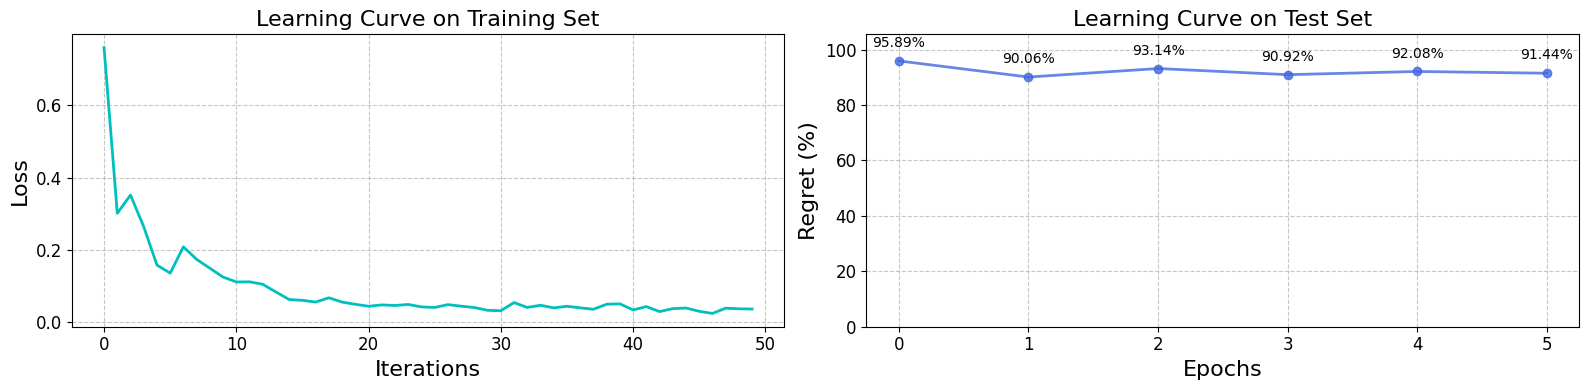

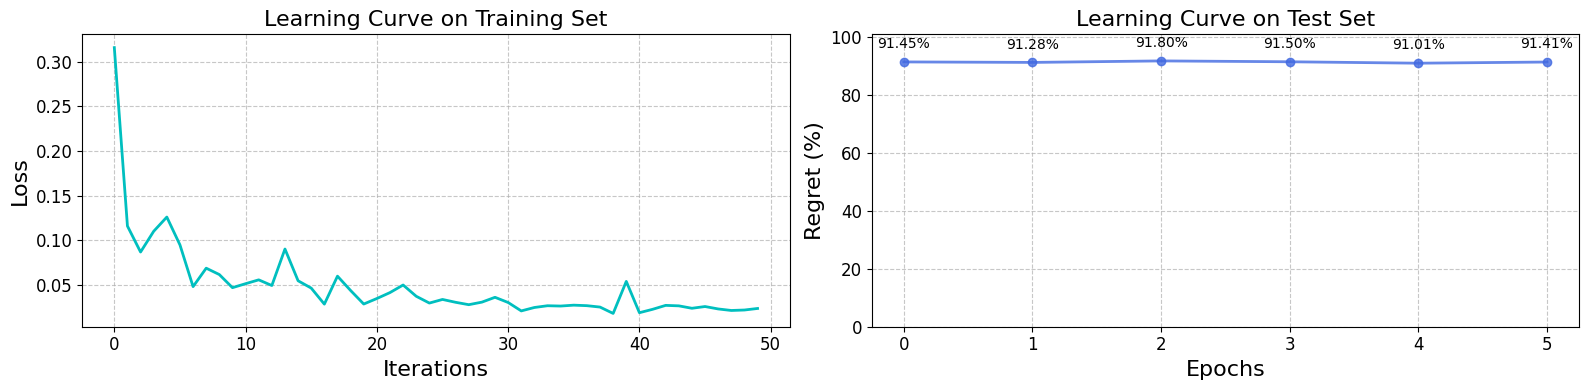

In [11]:
#############################################################################
# VISUALIZATION
#############################################################################
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    """Enhanced visualization with smoother curves and more information"""
    # Create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    
    # Plot training loss with smoothing for readability
    n_points = len(loss_log)
    
    # Apply smoothing for large datasets
    if n_points > 100:
        window_size = max(10, n_points // 50)
        smoothed_loss = np.convolve(loss_log, np.ones(window_size)/window_size, mode='valid')
        x_axis = np.arange(len(smoothed_loss))
        ax1.plot(x_axis, smoothed_loss, color="c", lw=2, label=f"Smoothed (window={window_size})")
        # Also plot the raw data with transparency
        ax1.plot(loss_log, color="c", lw=0.5, alpha=0.3, label="Raw")
        ax1.legend()
    else:
        # For smaller datasets, just plot the raw data
        ax1.plot(loss_log, color="c", lw=2)
    
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iterations", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Draw plot for regret on test set
    epochs = np.arange(len(loss_log_regret))
    ax2.plot(epochs, [r*100 for r in loss_log_regret], 
             color="royalblue", marker='o', ls="-", alpha=0.8, lw=2)
    
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, max(50, max([r*100 for r in loss_log_regret])*1.1))  # Dynamic y-limit
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret (%)", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add values to points
    for i, r in enumerate(loss_log_regret):
        ax2.annotate(f"{r*100:.2f}%", 
                     (i, r*100),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    # plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
    # print("Saved learning curves to 'learning_curves.png'")
    plt.show()

print("\nVisualizing learning curves...")
visLearningCurve(loss_log, loss_log_regret)
visLearningCurve(loss_log_fl, loss_log_regret_fl)